In [27]:
using LinearAlgebra
using Plots

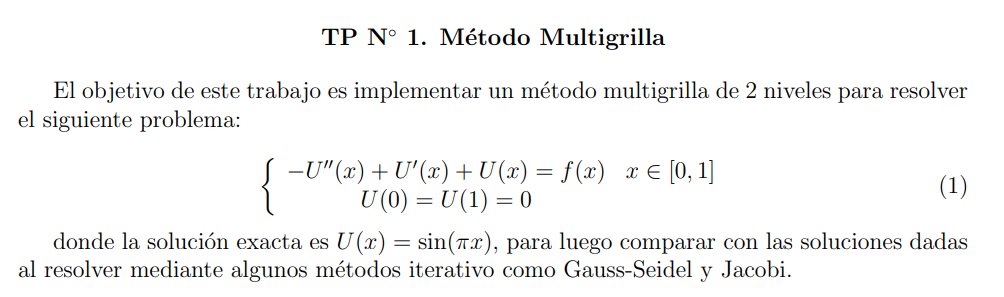

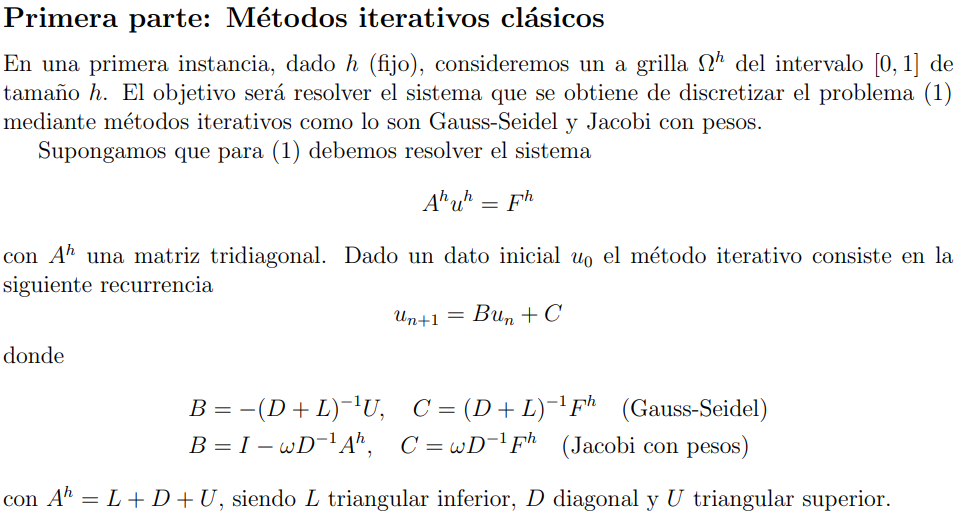

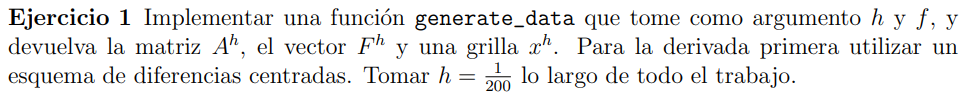

In [28]:
function generate_data(f;h=1/200)

    n = Int(1/h)

    #grilla de x
    x_h = [i/n for i in 1:n-1]

    F_h = -h^2*f.(x_h)

    # Definimos las tres diagonales de nuestra matriz
    diag = (-2 - h^2).* ones(n-1)     
    d_inf = (1+h/2).* ones(n-2)       
    d_sup = (1-h/2).* ones(n-2)

    # Creamos la matriz diagonal
    A_h = Tridiagonal(d_inf, diag, d_sup)
            
    return x_h, F_h, A_h
end

generate_data (generic function with 1 method)

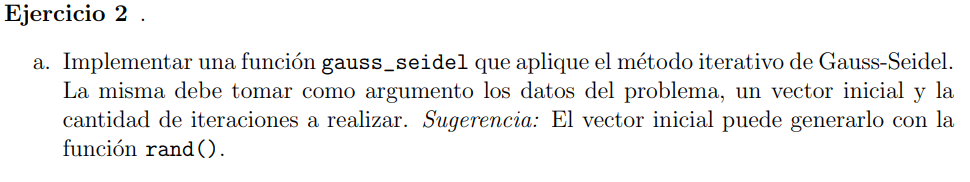

In [29]:
function gauss_seidel(A, F, m)
    #tamaño de la matriz
    n = size(A, 1)
    
    # Dato inicial aleatorio
    u = rand(n)

    for iter in 1:m
        for i in 1:n
            
            temp = sum(A[i,:]' * u)

            u[i] += (F[i]-temp)/A[i,i]
        end 
    end 
    return u 
    
end 

gauss_seidel (generic function with 1 method)

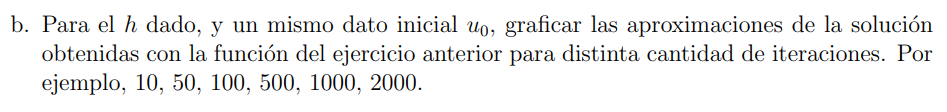

In [30]:
x_h, F_h, A_h = generate_data(x-> π^2*sin(π*x) + π*cos(x*π) + sin(π*x), h = 1/200)


([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05  …  0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995], [-8.2798435212059e-5, -8.703662480942415e-5, -9.125333942197456e-5, -9.544753863847564e-5, -9.961818760302984e-5, -0.00010376425727041194, -0.00010788472465997046, -0.00011197857310803295, -0.00011604479251875235, -0.00012008237961333329  …  3.506334212916561e-5, 3.946775997936926e-5, 4.386243975036675e-5, 4.824629712068363e-5, 5.261825043911095e-5, 5.697722099158607e-5, 6.132213326734999e-5, 6.565191522431295e-5, 6.996549855356513e-5, 7.426181894296532e-5], [-2.000025 0.9975 … 0.0 0.0; 1.0025 -2.000025 … 0.0 0.0; … ; 0.0 0.0 … -2.000025 0.9975; 0.0 0.0 … 1.0025 -2.000025])

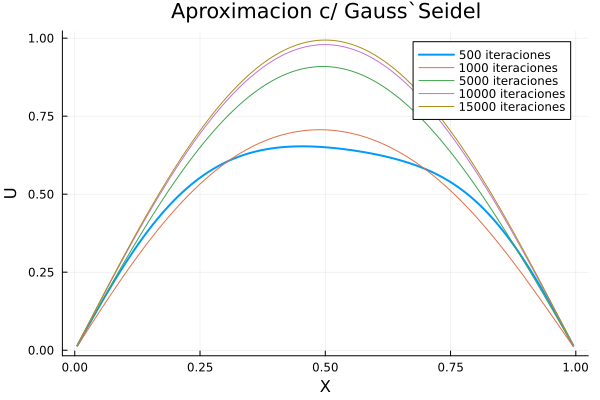

In [31]:
cant_iter = [1000,5000,10000,15000]

h= 1/200

n = Int(1/h)

#grilla de x
x_h = [i/n for i in 1:n-1]

v = gauss_seidel(A_h, F_h, 500)
p = plot(x_h, v, label="500 iteraciones", lw=2, xlabel="X", ylabel="U", title="Aproximacion c/ Gauss`Seidel", legend=:topright)
    

for c in cant_iter
    
    v = gauss_seidel(A_h, F_h, c)
    p = plot!(p,x_h, v, label="$c iteraciones")

end

display(p)

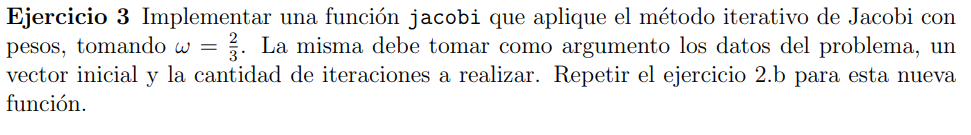

In [32]:
function jacobi_damped(A, b, m; ω = 2/3)
    #inicializamos los vectores u y de residuos
    u  = rand(size(A,1))
    r = b - A*u

    D = Diagonal(A)
    D_inv = inv(D)
    
    for iter in 1:m
        u = u + ω.*D_inv*r
        r  = b - A*u
    end

    return u 
end

jacobi_damped (generic function with 1 method)

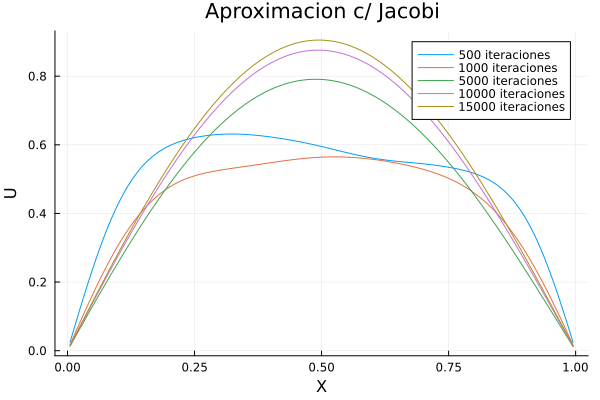

In [33]:
#grilla de x
x_h = [i/n for i in 1:n-1]

v = jacobi_damped(A_h, F_h, 500)
p = plot(x_h, v, label="500 iteraciones", lw=1, xlabel="X", ylabel="U", title="Aproximacion c/ Jacobi", legend=:topright)
    

for c in cant_iter
    
    v = jacobi_damped(A_h, F_h, c)
    p = plot!(p,x_h, v, label="$c iteraciones")

end

display(p)


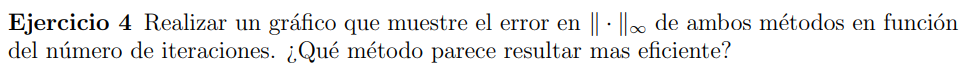

In [34]:
#Armamos un vector con los valores reales de la solucion 
u_real = sin.(π .* x_h)

#Calculamos el error en norma 
error_inf_GS = zeros(length(cant_iter))
error_inf_J = zeros(length(cant_iter))

for i in 1:length(cant_iter)
    u_aprox_GS = gauss_seidel(A_h, F_h, cant_iter[i])
    error_inf_GS[i] = maximum(abs.(u_aprox_GS - u_real))
    u_aprox_J = jacobi_damped(A_h, F_h, cant_iter[i])
    error_inf_J[i] = maximum(abs.(u_aprox_J - u_real))
end

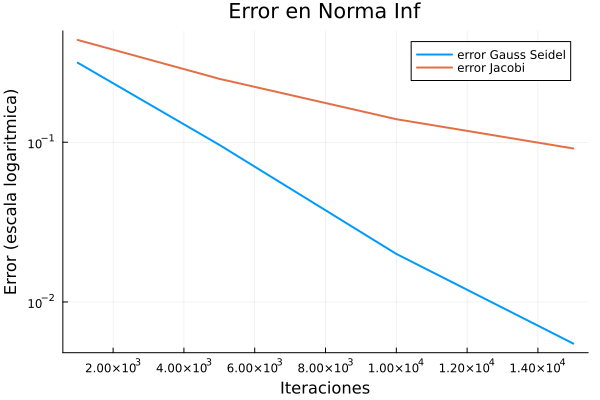

In [35]:
plot(cant_iter,error_inf_GS, lw=2, label="error Gauss Seidel", xlabel="Iteraciones", ylabel="Error (escala logaritmica)", title="Error en Norma Inf", legend=:topright, yscale=:log10)
plot!(cant_iter,error_inf_J, lw=2, label="error Jacobi")

Podemos ver que Gauss Seidel es mejor

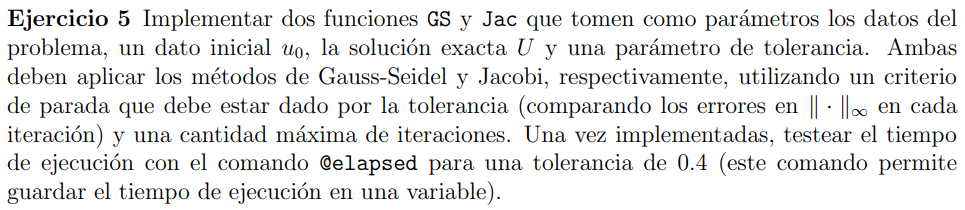

In [36]:
function GS(A, F, u0, U; ϵ = 1e-8, max_iter = 1e8)
    # copio u0
    u_copia = copy(u0)

    #tamaño de la matriz
    n = size(A, 1)

    error_inf = Inf
    iter = 0

    while iter < max_iter && error_inf > ϵ
        # realizo Gauss-Seidel
        for i in 1:n
            temp = sum(A[i,:]' * u_copia)
            u_copia[i] += (F[i]-temp)/A[i,i]
        end 

        # actualizo mis parametros de parada
        error_inf = maximum(abs.(u_copia - U))
        iter += 1
    end
    return u_copia, iter
end

GS (generic function with 1 method)

In [37]:
function Jac(A, F, u0, U; ϵ = 1e-8, max_iter = 1e8, ω = 2/3)
    # copio u0
    u_copia = copy(u0)

    #inicializamos el vector de residuos
    r = F - A*u_copia

    D = Diagonal(A)
    D_inv = inv(D)
    
    error_inf = Inf
    iter = 0

    while iter < max_iter && error_inf > ϵ
        # realizo Jacobi
        u_copia = u_copia + ω.*D_inv*r
        r  = F - A*u_copia

        # actualizo mis parametros de parada
        error_inf = maximum(abs.(u_copia - U))
        iter += 1
    end
    return u_copia, iter
end

Jac (generic function with 1 method)

In [38]:
# defino mis parametros 
x_h, F_h, A_h = generate_data(x-> π^2*sin(π*x) + π*cos(x*π) + sin(π*x), h = 1/200)

U = sin.(π .* x_h)


199-element Vector{Float64}:
 0.015707317311820675
 0.03141075907812829
 0.04710645070964266
 0.06279051952931337
 0.07845909572784494
 0.09410831331851431
 0.10973431109104528
 0.12533323356430426
 0.14090123193758267
 0.15643446504023087
 ⋮
 0.14090123193758286
 0.12533323356430454
 0.10973431109104564
 0.09410831331851435
 0.07845909572784507
 0.06279051952931358
 0.04710645070964296
 0.031410759078128236
 0.01570731731182071

In [39]:
u0 = zeros(length(x_h))

tiempo_GS = @elapsed u_GS, iters_GS = GS(A_h, F_h, u0, U; ϵ = 0.4)

0.3101707

In [40]:
iters_GS

3338

In [41]:
u1 = zeros(length(x_h))

tiempo_Jac = @elapsed u_Jac, iters_Jac = Jac(A_h, F_h, u1, U; ϵ = 0.4)

0.104564

In [42]:
iters_Jac

10044

In [43]:
print("Empezando del vector de ceros: ")
if tiempo_GS < tiempo_Jac
    print("Gauss-Seidel es mas rapido")
elseif tiempo_GS > tiempo_Jac
    print("Jacobi es mas rapido")
else
    print("Son igual de rapido")
end

Empezando del vector de ceros: Jacobi es mas rapido

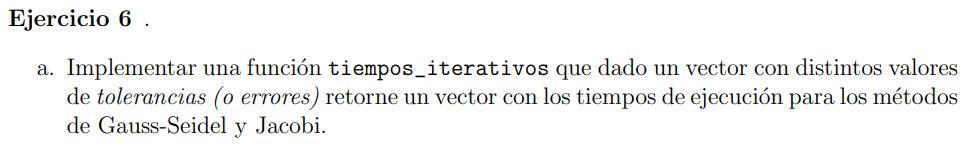

In [44]:
function tiempos_iterativos(tols; u0 = nothing)
    # defino mis parametros 
    x_h, F_h, A_h = generate_data(x-> π^2*sin(π*x) + π*cos(x*π) + sin(π*x), h = 1/200)

    U = sin.(π .* x_h)

    # inicio u0 si no me lo pasaron
    if isnothing(u0)
        u0 = rand(length(x_h))
    end

    tiempos_GS = zeros(Float64, length(tols))
    tiempos_Jac = zeros(Float64, length(tols))

    for i in 1:length(tols)
        tiempos_GS[i] = @elapsed GS(A_h, F_h, u0, U; ϵ = tols[i])
        tiempos_Jac[i] = @elapsed Jac(A_h, F_h, u0, U; ϵ =tols[i])
    end
    return tiempos_GS, tiempos_Jac, u0
end


tiempos_iterativos (generic function with 1 method)

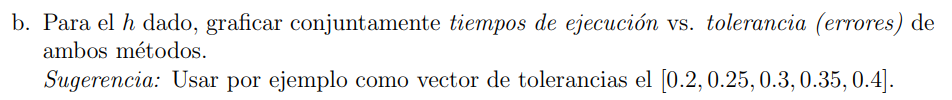

In [45]:
tols = [0.2, 0.25, 0.3, 0.35, 0.4]

tiempos_GS, tiempos_Jac, u0 = tiempos_iterativos(tols)

([0.1604282, 0.1287664, 0.0728299, 0.0486064, 0.0332911], [0.0137781, 0.0065283, 0.0046286, 0.002917, 0.0020112], [0.2769992890191679, 0.36744447457262475, 0.5049798395161912, 0.22180407797983404, 0.1961530349161683, 0.15685913915215643, 0.06925943676057744, 0.28686833059255445, 0.8018983654346548, 0.3315144629003277  …  0.006573237403783461, 0.8963992234578464, 0.9710490223885994, 0.7838893782058503, 0.9892444550664817, 0.591088905777594, 0.443211438091514, 0.4717563365650008, 0.6352982456950402, 0.5250169168060907])

u0 = [0.2769992890191679, 0.36744447457262475, 0.5049798395161912, 0.22180407797983404, 0.1961530349161683, 0.15685913915215643, 0.06925943676057744, 0.28686833059255445, 0.8018983654346548, 0.3315144629003277, 0.2895423165598965, 0.6749311464768697, 0.06825190766249423, 0.056552835903806, 0.511189080141367, 0.943243959489912, 0.7607006335044302, 0.20763811166840962, 0.8197257943751872, 0.7884396290512616, 0.16965966606317973, 0.9272747604936173, 0.8918642061058704, 0.5907839268492578, 0.004927360968094763, 0.7858306267428918, 0.568352697609401, 0.6095270939297331, 0.1456749750575168, 0.8033853734593447, 0.7678670295614406, 0.5018630917067269, 0.9948267868308796, 0.4963682494155598, 0.27531271693623216, 0.9213844378377011, 0.8835630480975168, 0.7907261633412086, 0.356091895422603, 0.32879593594457124, 0.6479351168095852, 0.8750954181960207, 0.35838274240224655, 0.9139462022754322, 0.49339100364749766, 0.3999771896444039, 0.1036068667913933, 0.6475626165426075, 0.7001008663079883, 0.617

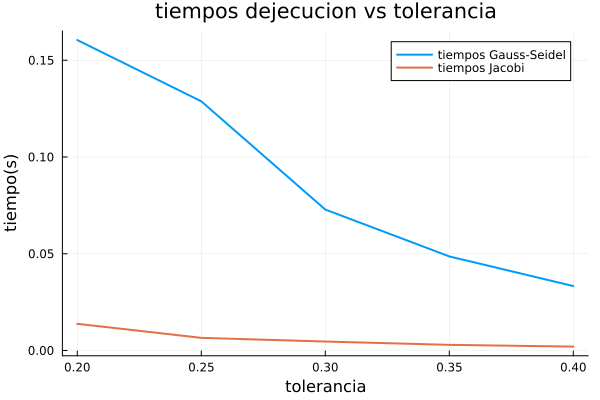

In [46]:
@show(u0)
plot(tols, tiempos_GS, lw=2, title="tiempos dejecucion vs tolerancia", xlabel="tolerancia", ylabel="tiempo(s)", label= "tiempos Gauss-Seidel", legend=:topright)
plot!(tols, tiempos_Jac, lw=2, label="tiempos Jacobi")

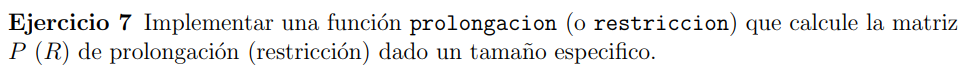

Si $\Omega^{2h}$ y $\Omega^{h}$ respresentan nuestros esquemas para h y 2h respectivamente la funcion P(R) debe ser de la forma P : $\Omega^{2h} \rightarrow \Omega^{h}$

In [47]:
function prologacion(N::Int)
    N = N + 1
    #N debe ser mayor a 2
    filas = N - 1
    cols = div(N,2) - 1
    A = zeros(Int, filas, cols)  # inicializamos una matrix nula

    for j in 1:cols
        comienzaFila = 2 * (j - 1) + 1  # Calculamos la fila donde esta el primer numero no nulo
        
        # Asignamos 1, 2, 1 siempre que estemos en el rango de la matriz
        if comienzaFila <= filas
            A[comienzaFila, j] = 1
        end
        if comienzaFila + 1 <= filas
            A[comienzaFila + 1, j] = 2
        end
        if comienzaFila + 2 <= filas
            A[comienzaFila + 2, j] = 1
        end
    end
    
    return (1/2)*A
end

prologacion (generic function with 1 method)

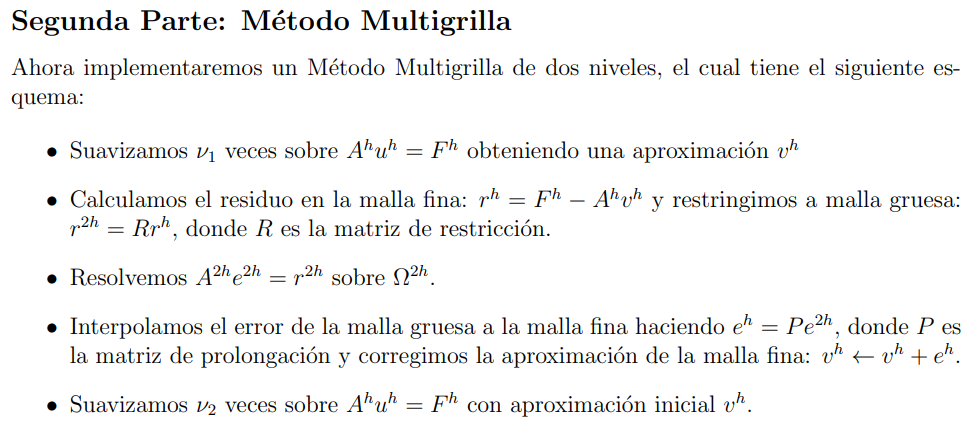

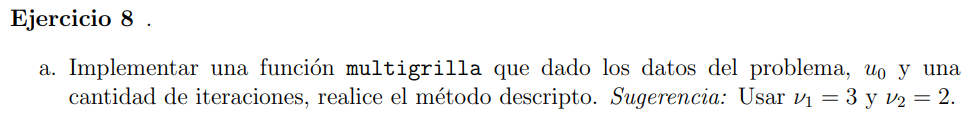

In [48]:
function multigrilla(A, F, u0, U,f; ϵ = 1e-8, ν1 = 3, ν2 = 2) #(h,x_h, F_h, A_h, u0, cant_iter) 
    n = length(u0)
    # inicializamos el vector a devolver
    vh = zeros(n)   
    # hacemos ν1 veces Jacobi
    vh, _ = Jac(A, F, u0, U, max_iter = ν1)
    # calculamos el residuo de la malla fina

    rh = F - A * vh

    # restringimos a la malla gruesa
    P = prologacion(n)

    r2h = (1/2)*P'*rh

    # resolvemos A*e = r en la grilla 2h
    _, _, A2h = generate_data(f,h=2/200)

    e2h = A2h\r2h

    #prolongamos e2h
    eh = P * e2h
    vh = vh + eh
    # hacemos ν2 veces Jacobi
    res, _ = Jac(A, F, vh, U, max_iter = ν2)

    return res

end

multigrilla (generic function with 1 method)

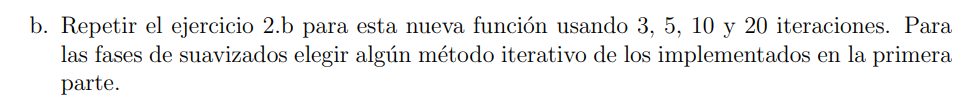

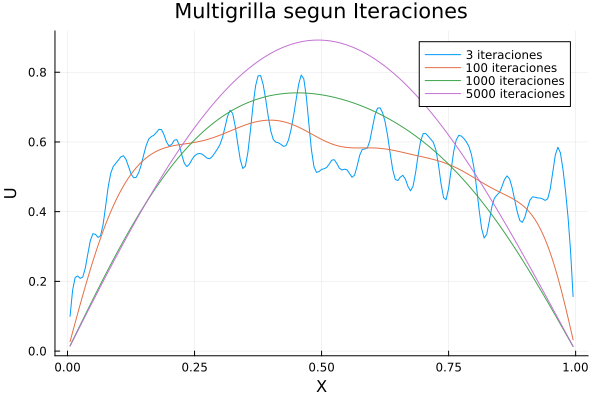

In [49]:
#Definimos nuestras grillas y datos iniciales 
U = sin.(π .* x_h)
f(x) = π^2*sin(π*x) + π*cos(x*π) + sin(π*x)

x_h, F_h, A_h = generate_data(x-> π^2*sin(π*x) + π*cos(x*π) + sin(π*x), h = 1/200)

u_0 = rand(length(x_h))

iter = [100,1000,5000]

v = multigrilla(A_h, F_h, u0, U, f)

p = plot(x_h, v, label="3 iteraciones", lw=1, xlabel="X", ylabel="U", title="Multigrilla segun Iteraciones", legend=:topright)
    
for i in iter
    
    v = multigrilla(A_h, F_h, u0, U, f; ϵ = 1e-8, ν1 = i, ν2 = i)
    
    p = plot!(p,x_h, v, label="$i iteraciones")
end

display(p)


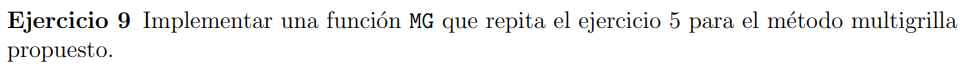

In [59]:
function MG(A, F, u0, U, f; ϵ = 1e-8, max_iter = 1e8)
    # Vector que iremos modificando, lo inicializamos con una primera iteración del método
    uₙ = multigrilla(A, F, u0, U, f)
    
    # Inicializamos el error en norma infinito
    eₙ = maximum(abs.(uₙ - U))
    
    # Inicializamos variable de iteraciones
    iter = 1

    while eₙ > ϵ && iter < max_iter
        uₙ = multigrilla(A, F, uₙ, U, f)  # Updated to use uₙ in the loop
        iter += 1
        eₙ = maximum(abs.(uₙ - U))
    end 

    return uₙ, eₙ, iter
end


MG (generic function with 2 methods)

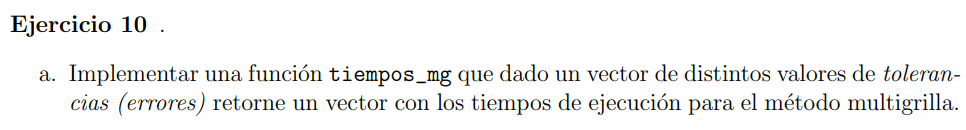

In [60]:
function tiempos_mg(tols; u0 = nothing)
    f(x) = π^2*sin(π*x) + π*cos(x*π) + sin(π*x)

    # defino mis parametros 
    x_h, F_h, A_h = generate_data(f, h = 1/200)

    U = sin.(π .* x_h)

    # inicio u0 si no me lo pasaron
    if isnothing(u0)
        u0 = rand(length(x_h))
    end

    tiempos = zeros(Float64, length(tols))

    for i in 1:length(tols)
        tiempos[i] = @elapsed MG(A_h, F_h, u0, U, f, ϵ = tols[i])
    end
    return tiempos, u0
end

tiempos_mg (generic function with 1 method)

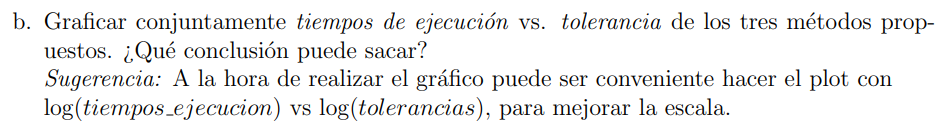

In [70]:
tols = [0.2, 0.25, 0.3, 0.35, 0.4]

tiempo_GS, tiempo_Jac, u0 = tiempos_iterativos(tols)

tiempo_mg = tiempos_mg(tols, u0 = u0)

([0.0002133, 0.000157, 0.0001577, 0.0001209, 0.0001712], [0.8093405294652024, 0.7685879086384518, 0.7305528318215961, 0.7629427462375933, 0.7953727378374407, 0.8440989839354515, 0.37722731857058145, 0.0066486781709381715, 0.5915663854638785, 0.2568455385782189  …  0.22232481941282578, 0.18588371623266242, 0.3458965466734595, 0.43563493819497767, 0.5058941983085785, 0.02251378595042519, 0.2475036809541702, 0.7429550091786101, 0.03449429638870316, 0.2737501317804728])

u0 = [0.8093405294652024, 0.7685879086384518, 0.7305528318215961, 0.7629427462375933, 0.7953727378374407, 0.8440989839354515, 0.37722731857058145, 0.0066486781709381715, 0.5915663854638785, 0.2568455385782189, 0.6806128316583152, 0.17426852953191718, 0.2278679857680206, 0.6992268022753368, 0.7493031274042032, 0.46887926266543545, 0.00018840892029192702, 0.1487516213073936, 0.3165249029964522, 0.2093252807283048, 0.27112478496714754, 0.2516786975779387, 0.6518812374218417, 0.9763242093144603, 0.9413580905954302, 0.8161670047099109, 0.3821641711041408, 0.7193120639404874, 0.189587030561588, 0.2800931093715412, 0.024963066281594726, 0.7435912536459484, 0.7271639304332528, 0.26205783259410165, 0.039697073194461474, 0.5725836844534814, 0.1479946022188855, 0.8350843017078808, 0.38094673634055787, 0.762611375468812, 0.5125089997961138, 0.7003533263648227, 0.5731367530653112, 0.7776883141229509, 0.14918151555874104, 0.2981120643103464, 0.3466869311428976, 0.46390134779822934, 0.056858335072483

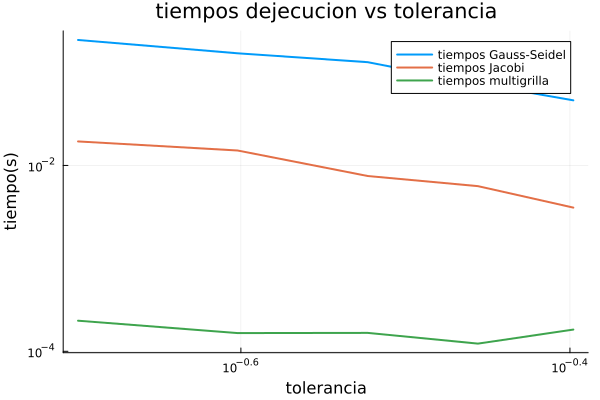

In [71]:
@show(u0)
plot(tols, tiempo_GS, xscale=:log10, yscale=:log10, lw=2, title="tiempos dejecucion vs tolerancia", xlabel="tolerancia", ylabel="tiempo(s)", label= "tiempos Gauss-Seidel", legend=:topright)
plot!(tols, tiempo_Jac, lw=2, label="tiempos Jacobi")
plot!(tols, tiempo_mg, lw=2, label="tiempos multigrilla")